<a href="https://colab.research.google.com/github/Jules-gatete/Intro_to_ML---Summatives/blob/main/Summative_Intro_to_ml_Jules_Gatete_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2
from sklearn.compose import ColumnTransformer
import joblib


In [2]:
# Load the dataset
file_path = "/content/Drug prescription Dataset.csv"
df = pd.read_csv(file_path)

# Display basic info
print(df.head())
print(df.info())
print(df.describe())

    disease  age gender severity                drug
0  diarrhea    4   male      LOW  promegranate drink
1  diarrhea    4   male   NORMAL          lime juice
2  diarrhea    5   male      LOW  promegranate drink
3  diarrhea    5   male   NORMAL          lime juice
4  diarrhea    6   male      LOW  promegranate drink
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1288 non-null   object
 1   age       1288 non-null   int64 
 2   gender    1288 non-null   object
 3   severity  1288 non-null   object
 4   drug      1288 non-null   object
dtypes: int64(1), object(4)
memory usage: 50.4+ KB
None
               age
count  1288.000000
mean     33.645963
std      15.532570
min       4.000000
25%      20.000000
50%      34.000000
75%      47.000000
max      60.000000


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 disease     0
age         0
gender      0
severity    0
drug        0
dtype: int64


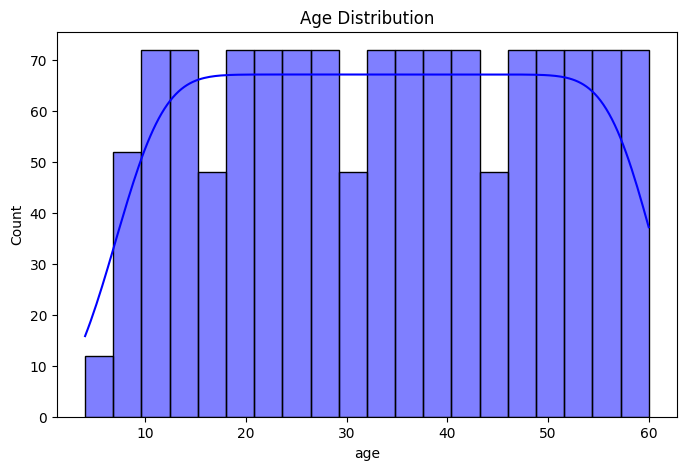

In [4]:
# Visualize the distribution of numerical data
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=20, kde=True, color="blue")
plt.title("Age Distribution")
plt.show()

In [5]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {duplicates}")

# Drop duplicates if any
df = df.drop_duplicates()


Duplicate Rows: 0


In [6]:
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]
print(f"Outliers detected in 'age': {len(outliers)}")


Outliers detected in 'age': 0


In [7]:
# Encode categorical variables and store mappings
label_encoders = {}
label_mappings = {}
categorical_columns = ["disease", "gender", "severity", "drug"]

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    label_mappings[col] = dict(enumerate(le.classes_))  # Save mapping

# Split dataset into features and target variable
X = df.drop(columns=["drug"])  # Features
y = df["drug"]  # Target variable

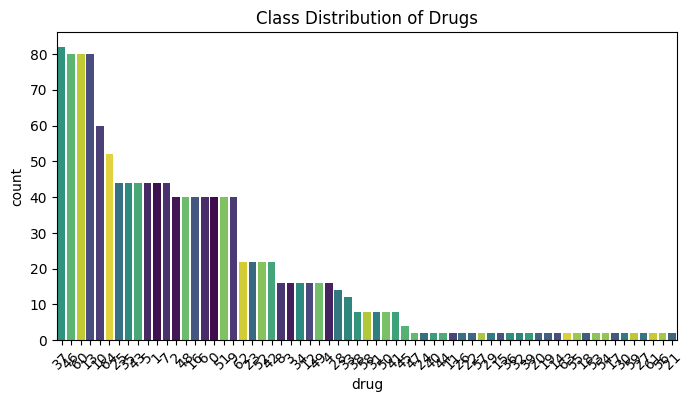

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x=df["drug"], hue=df["drug"], palette="viridis", order=df["drug"].value_counts().index, legend=False)
plt.title("Class Distribution of Drugs")
plt.xticks(rotation=45)
plt.show()

In [9]:
# Split dataset into features and target variable
X = df.drop(columns=["drug"])  # Features
y = df["drug"]  # Target variable

# Step 1: Split into 60% training and 40% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Step 2: Ensure stratification is only used if class count >1
class_counts = y_temp.value_counts()
stratify_param = y_temp if class_counts.min() >= 2 else None

# Step 3: Split the 40% temporary set into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=stratify_param)

In [10]:
# Fix SettingWithCopyWarning
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

In [11]:
# Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["age"]),  # Scale age
        ('cat', "passthrough", X.columns.difference(["age"]))  # Keep categorical as is
    ]
)

# Apply transformation
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


In [12]:
# Print dataset sizes
dataset_sizes = {
    "Training data": X_train.shape[0],
    "Validation data": X_val.shape[0],
    "Testing data": X_test.shape[0]
}

print(f"Training data: {X_train.shape[0]} samples")
print(f"Validation data: {X_val.shape[0]} samples")
print(f"Testing data: {X_test.shape[0]} samples")

Training data: 772 samples
Validation data: 258 samples
Testing data: 258 samples


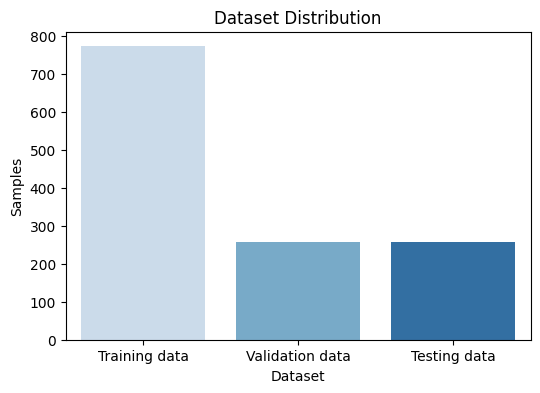

In [13]:
# Convert dataset sizes to DataFrame for visualization
df_sizes = pd.DataFrame(dataset_sizes.items(), columns=["Dataset", "Samples"])

# Plot the dataset size distribution
plt.figure(figsize=(6, 4))
sns.barplot(x="Dataset", y="Samples", hue="Dataset", data=df_sizes, palette="Blues", dodge=False)
plt.title("Dataset Distribution")
plt.xlabel("Dataset")
plt.ylabel("Samples")
plt.show()


# 📌 Function to train and evaluate models


In [14]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name, history=None):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"\n📊 Performance Metrics - {model_name}:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    # Plot accuracy training history for all models
    if isinstance(model, Sequential) and history is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"Training History - {model_name}")
        plt.legend()
        plt.show()

    # Plot Confusion Matrix for all models, including Logistic Regression
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return metrics


#**Implement** **Models**

## Logistic Regression (Classical ML)



📊 Performance Metrics - Logistic Regression:
Accuracy: 0.6589
Precision: 0.6770
Recall: 0.6589
F1 Score: 0.6136


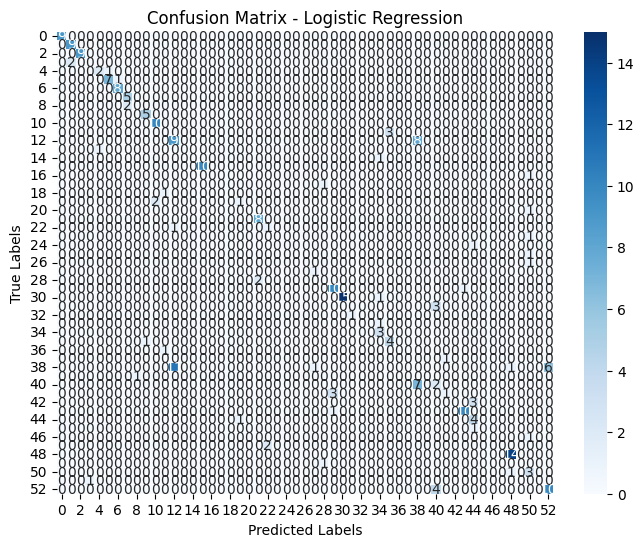

In [15]:
# Train and Evaluate Logistic Regression Model
log_reg = LogisticRegression(max_iter=2000, solver='newton-cg', C=1.0)
log_reg.fit(X_train, y_train)

# Store the returned metrics in a variable
log_reg_metrics = evaluate_model(log_reg, X_test, y_test, "Logistic Regression")


## Simple Neural Network (No Optimization) =





9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📊 Performance Metrics - Simple Neural Network:
Accuracy: 0.8837
Precision: 0.9237
Recall: 0.8837
F1 Score: 0.8605


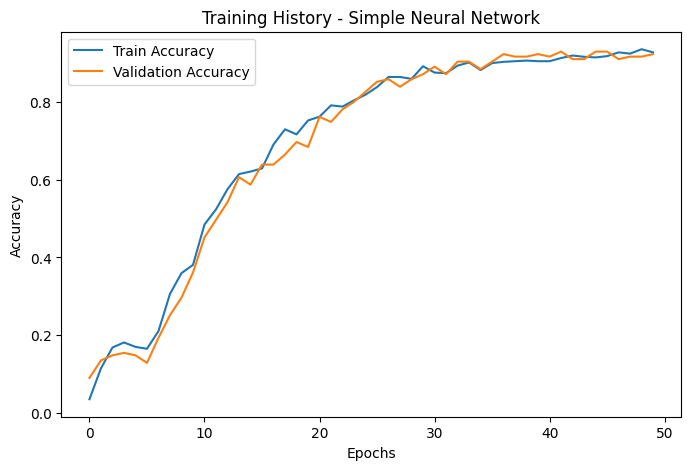

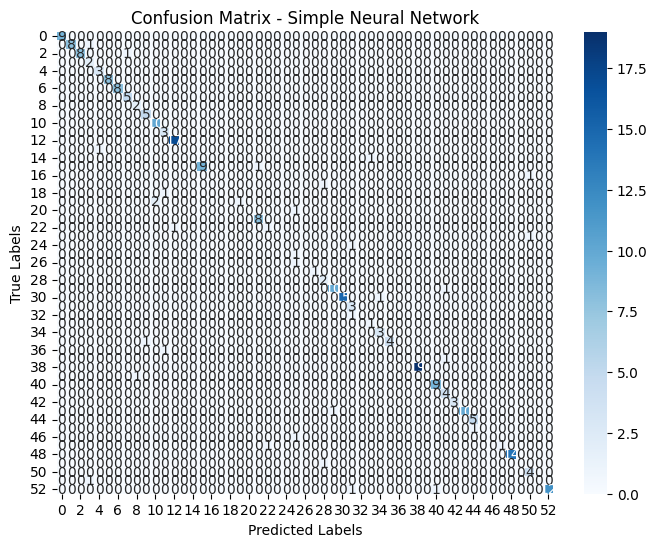

In [16]:
# Train and Evaluate Simple Neural Network (No Optimization)
simple_nn = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])
simple_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = simple_nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
# Pass the history object to the evaluate_model function
simple_nn_metrics = evaluate_model(simple_nn, X_test, y_test, "Simple Neural Network", history=history)
#Update the function to receive the history

# **Optimized Neural Networks**

## Model 1: Adam Optimizer + L1 Regularization


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

📊 Performance Metrics - Adam + L1 Regularization:
Accuracy: 0.8915
Precision: 0.9293
Recall: 0.8915
F1 Score: 0.8674


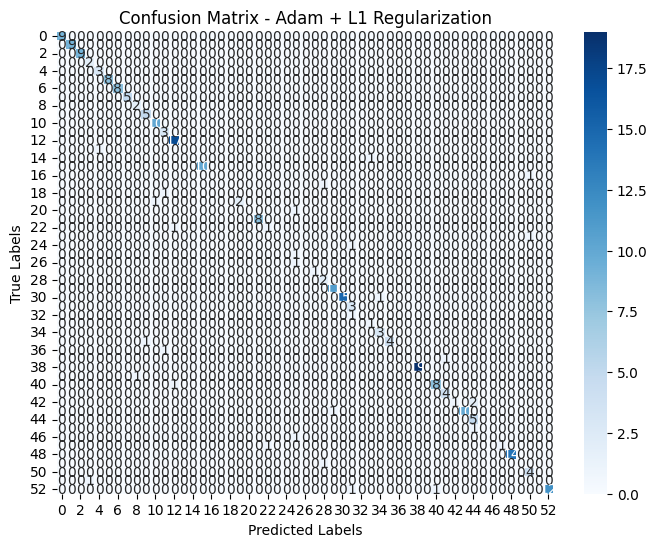

In [20]:
# Train and Evaluate Model 1: Adam Optimizer + L1 Regularization
adam_l1_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l1(0.001)),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='softmax')
])
adam_l1_model.compile(optimizer=Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
adam_l1_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
adam_l1_metrics = evaluate_model(adam_l1_model, X_test, y_test, "Adam + L1 Regularization")

## Model 2: RMSProp Optimizer + L2 Regularization




9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

📊 Performance Metrics - RMSProp + L2 Regularization:
Accuracy: 0.8643
Precision: 0.9123
Recall: 0.8643
F1 Score: 0.8433


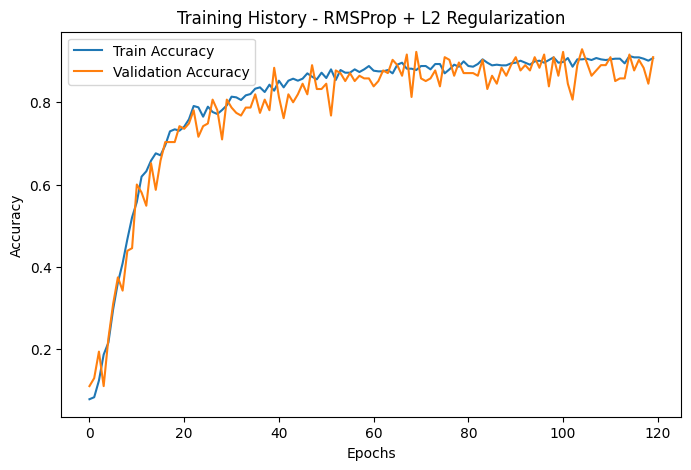

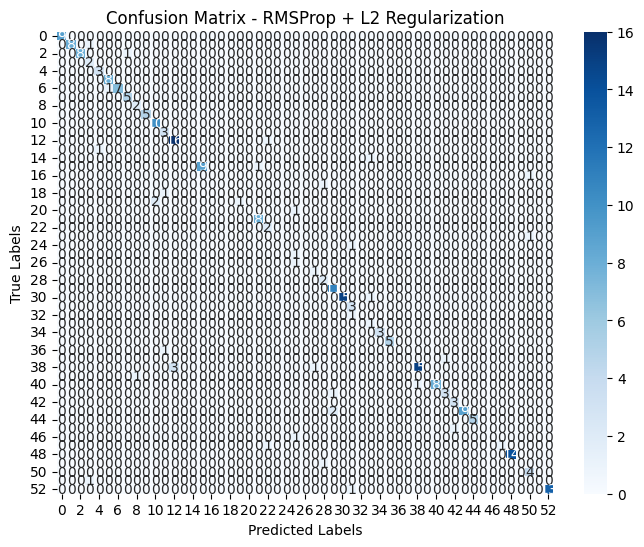

In [23]:
#RMSProp Optimizer + L2 Regularization
rmsprop_l2_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(np.unique(y)), activation='softmax')
])
rmsprop_l2_model.compile(optimizer=RMSprop(learning_rate=0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_rmsprop = rmsprop_l2_model.fit(X_train, y_train, epochs=120, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
rmsprop_l2_metrics = evaluate_model(rmsprop_l2_model, X_test, y_test, "RMSProp + L2 Regularization", history_rmsprop)

## Model 3: SGD Optimizer + L1 Regularization


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📊 Performance Metrics - SGD + L1 Regularization:
Accuracy: 0.7829
Precision: 0.8821
Recall: 0.7829
F1 Score: 0.7451


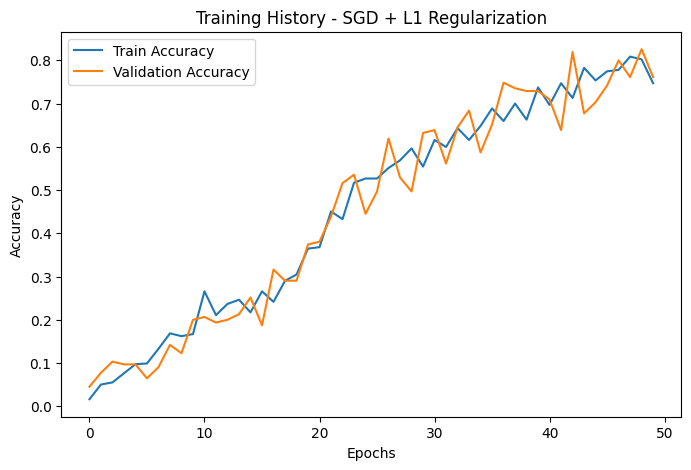

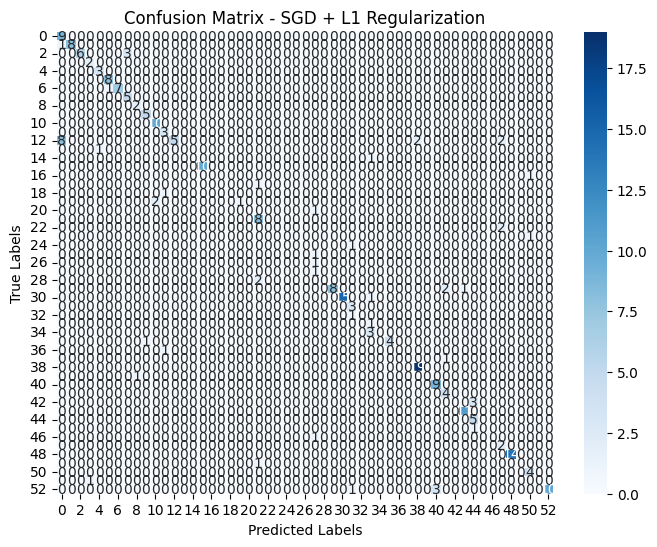

In [19]:
#SGD Optimizer + L1 Regularization
sgd_l1_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(len(np.unique(y)), activation='softmax')
])
sgd_l1_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_sgd = sgd_l1_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
sgd_l1_metrics = evaluate_model(sgd_l1_model, X_test, y_test, "SGD + L1 Regularization", history_sgd)
